# Stock Price machine Learning

-----------------------------------
## Historical Data Pull for Amazon

In [3]:
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import numpy as np

# Dates
today = pd.Timestamp.today().strftime('%Y-%m-%d')
one_year_ago = (pd.Timestamp.today() - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Ticker symbol
ticker = 'AMZN'

# Data Pull
hist_data = yf.download(ticker, start=one_year_ago, end=today,progress=False)

# Ensure data is in a DataFrame with datetime index
df = pd.DataFrame(hist_data)
df.index = pd.to_datetime(df.index)  # Ensure datetime index
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-05,130.240005,131.399994,129.639999,130.380005,130.380005,35895400
2023-07-06,128.250000,128.729996,127.370003,128.360001,128.360001,40639900
2023-07-07,128.589996,130.970001,128.130005,129.779999,129.779999,41928700
2023-07-10,129.070007,129.279999,125.919998,127.129997,127.129997,61889300
2023-07-11,127.750000,129.770004,127.349998,128.779999,128.779999,49951500
...,...,...,...,...,...,...
2024-06-27,195.009995,199.839996,194.199997,197.850006,197.850006,74397500
2024-06-28,197.729996,198.850006,192.500000,193.250000,193.250000,76930200
2024-07-01,193.490005,198.300003,192.820007,197.199997,197.199997,41192000


### Adjusted Close Plot for Visual

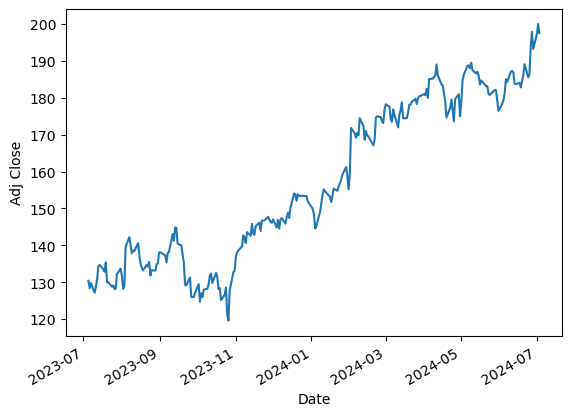

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

## Technical Indicator Calculations

In [5]:
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [6]:
# Calculate Moving Averages
df.ta.sma(length=7, append=True)
df.ta.sma(length=14, append=True)
df.ta.sma(length=30, append=True)
df.ta.sma(length=50, append=True)
df.ta.sma(length=200, append=True)

# Calculate Bollinger Bands
df.ta.bbands(length=20, append=True) #volatility

# Calculate RSI
df.ta.rsi(length=14, append=True)

# Calculate MACD 
df.ta.macd(fast=12, slow=26, append=True)

print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-07-05  130.240005  131.399994  129.639999  130.380005  130.380005   
2023-07-06  128.250000  128.729996  127.370003  128.360001  128.360001   
2023-07-07  128.589996  130.970001  128.130005  129.779999  129.779999   
2023-07-10  129.070007  129.279999  125.919998  127.129997  127.129997   
2023-07-11  127.750000  129.770004  127.349998  128.779999  128.779999   
...                ...         ...         ...         ...         ...   
2024-06-27  195.009995  199.839996  194.199997  197.850006  197.850006   
2024-06-28  197.729996  198.850006  192.500000  193.250000  193.250000   
2024-07-01  193.490005  198.300003  192.820007  197.199997  197.199997   
2024-07-02  197.279999  200.429993  195.929993  200.000000  200.000000   
2024-07-03  199.940002  200.029999  196.759995  197.589996  197.589996   

              Volume       SMA_7     

### Good Data Pull so far with calculations 
More Technical Indicators can be added as we go. Now for some plotting to get some visuals of what the data looks like.

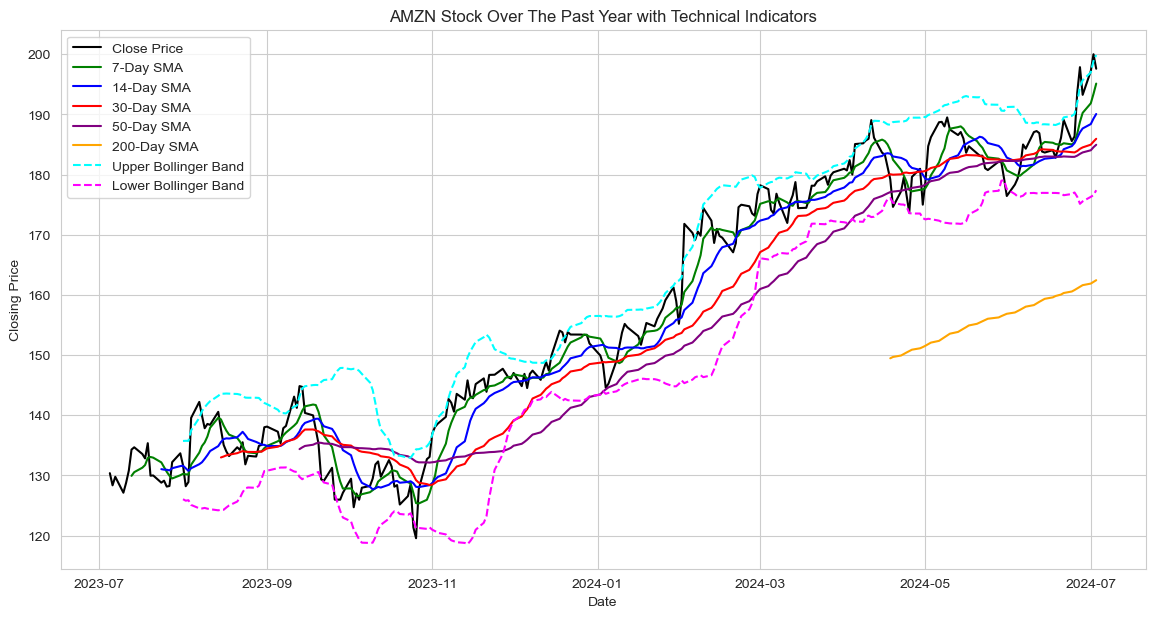

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize =(14,7))
# Moving Aveerages
plt.plot(df.index, df['Close'], label = 'Close Price', color = 'black')
plt.plot(df.index,df['SMA_7'],label = '7-Day SMA', color = 'green')
plt.plot(df.index, df['SMA_14'],label = '14-Day SMA',color = 'blue')
plt.plot(df.index, df['SMA_30'],label = '30-Day SMA', color = 'red')
plt.plot(df.index,df['SMA_50'], label = '50-Day SMA',color = 'purple')
plt.plot(df.index, df['SMA_200'], label = '200-Day SMA',color = 'orange')
# Bollinger Bands
plt.plot(df.index,df['BBU_20_2.0'],label = 'Upper Bollinger Band',color = 'cyan',linestyle = '--')
plt.plot(df.index,df['BBL_20_2.0'],label = 'Lower Bollinger Band',color = 'magenta',linestyle = '--')

plt.title('AMZN Stock Over The Past Year with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### Adding some more technical indicators

In [16]:
# Full technical indicators minus other previous additions
df.ta.aberration(append=True) #volatility
df.ta.above(above_value=100, append=True)
df.ta.accbands(append=True) # volatility
df.ta.ad(append=True) # volume
df.ta.adosc(append=True) # volume
df.ta.adx(append=True) # trends
df.ta.alma(append=True) #overlap
df.ta.amat(append=True) # trends
df.ta.ao(append=True) # momentum
df.ta.aobv(append=True) # volume
df.ta.apo(append=True)# momentum
df.ta.aroon(append=True) # trends
df.ta.atr(append=True) # volatility
df.ta.below(below_value=50, append=True) 
df.ta.bias(append=True) # momentum
df.ta.bop(append=True) # momentum
df.ta.brar(append=True) # momentum
df.ta.cci(append=True)  # momentum
df.ta.cfo(append=True) # momentum
df.ta.cg(append=True) # momentum
df.ta.cmo(append=True) #momentum
df.ta.coppock(append=True) #momentum
df.ta.cti(append=True


Date
2023-07-05          NaN
2023-07-06          NaN
2023-07-07          NaN
2023-07-10          NaN
2023-07-11          NaN
                ...    
2024-06-27     7.900573
2024-06-28     8.199016
2024-07-01     9.199554
2024-07-02    10.592322
2024-07-03    11.316689
Name: COPC_11_14_10, Length: 252, dtype: float64

In [11]:
df.to_csv('amazon_current.csv')